# Run it

To run it use

`docker build -f Keras.Dockerfile -t keras .`

`docker run -v ${PWD}:/notebooks -p 8888:8888 keras` 

## Data preparation



In [1]:
%matplotlib inline

from matplotlib.pyplot import imshow, figure
import imageio 

def show_image(img):
    imshow(img, cmap='gray')

def load_video(file_path, n_images):
    images = []
    for i in range(n_images):
        image = imageio.imread(file_path + ('%010d.png') % i)
        images.append(image)
    
    return images


In [2]:
num_images_1 = 114
num_images_2 = 149
num_images = num_images_1 + num_images_2
image_size = (177, 480)

images = load_video('../data/2011_09_26/2011_09_26_drive_0001_extract/image_00/data/downsized/', num_images_1) + load_video('../data/2011_09_26/2011_09_26_drive_0001_extract/image_01/data/downsized/', num_images_2)


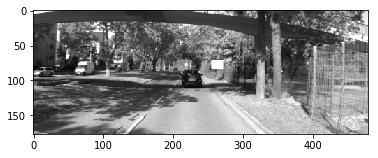

In [3]:
show_image(images[200])


In [4]:
def flatten(seqs):
    seq = []
    for s in seqs:
        seq = seq + s
    return seq

from itertools import islice

def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

## Preprocess


In [5]:
import numpy as np

max_length = 3

def flatten(image):
    return image.flatten()

def to_channels(image):
    return image[:,:,np.newaxis]

data = list(window(images, max_length+1))

xs = [[to_channels(i) for i in x[:max_length]] for x in data]
ys = [to_channels(x[max_length]) for x in data]

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, Conv2D, Conv3D, AveragePooling3D, MaxPooling3D, Reshape
from keras.layers.recurrent import LSTM

import numpy as np

model = Sequential()
model.add(Conv3D(filters=1, kernel_size=(3,8,8), kernel_initializer='random_uniform', padding='same', input_shape=(3, image_size[0], image_size[1], 1), data_format="channels_last"))
model.add(MaxPooling3D(pool_size=(3, 1, 1), padding='same'))
model.add(Reshape((image_size[0], image_size[1], 1)))
model.add(Conv2D(filters=1, kernel_size=(8,8), kernel_initializer='random_uniform', padding='same', data_format="channels_last"))

print(model.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_10 (Conv3D)           (None, 3, 177, 480, 1)    193       
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 1, 177, 480, 1)    0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 177, 480, 1)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 177, 480, 1)       65        
Total params: 258
Trainable params: 258
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
model.compile(optimizer='adam', loss='mse')
model.fit(np.array(xs), np.array(ys), epochs=2, batch_size=8)

Epoch 1/2
260/260 [==============================] - 184s 706ms/step - loss: 8445.9364
Epoch 2/2
260/260 [==============================] - 187s 718ms/step - loss: 1274.5712


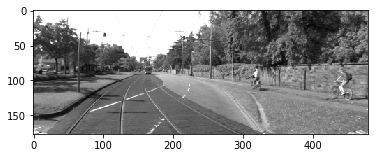

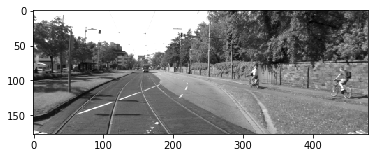

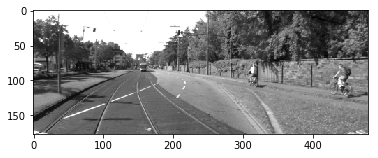

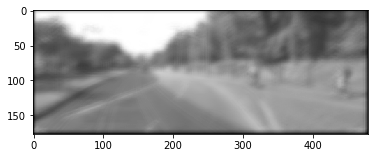

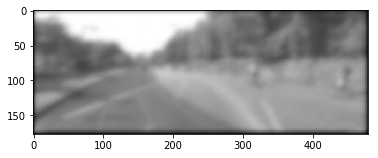

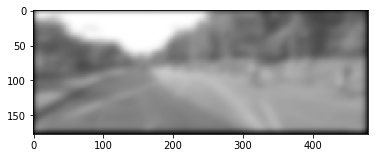

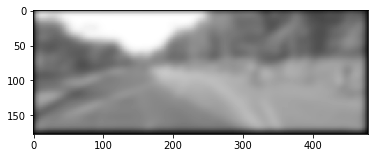

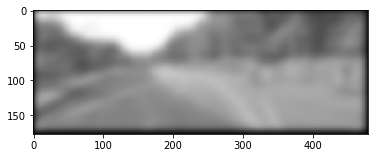

In [19]:
valid = load_video('../data/2011_09_26/2011_09_26_drive_0001_extract/image_02/data/downsized/', 5)

def continue_video(images, n):
    if n == 0:
        return
    
    result = model.predict(np.array([images]))
    figure()
    show_image(result[0].reshape(image_size))
    
    continue_video([images[1], images[2], result[0]], n-1)
        
start_idx = 3
start = [to_channels(valid[start_idx-2]), to_channels(valid[start_idx-1]), to_channels(valid[start_idx])]
figure()
show_image(start[0].reshape(image_size))
figure()
show_image(start[1].reshape(image_size))
figure()
show_image(start[2].reshape(image_size))
continue_video(start, 5)